<a href="https://colab.research.google.com/github/koad7/uol_final/blob/main/FINAL_UOL_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -q  transformers
!pip install -q nltk node2vec
!pip install -q haversine
!pip  install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00


In [1]:
from pathlib import Path
from google.colab import drive
import os
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pickle
import copy
import numpy as np
import gc

In [2]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/')
FINAL_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/final_work')
WORKDIR_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/')

In [4]:
what = 'read'
if what == 'read':
  train_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_10_15.parquet')
  test_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_10_15.parquet')
  val_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_10_15.parquet')


In [183]:
train_df = train_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:70]
val_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]
test_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]

# BASELINE MODELS

## Create the knowledge graph

In [184]:
def create_knowledge_graph(df):
    G = nx.DiGraph()

    for idx, row in df.iterrows():
        country = row['country']
        location = row['location']
        location_latitude = row['location_latitude']
        location_longitude = row['location_longitude']
        osm_id = row['osm_id']
        region = row['region']
        sub_region = row['sub_region']


        # Add nodes
        if pd.notna(country) and country!= '':
            G.add_node(country, country=country, type='Country')
        if pd.notna(location) and location!= '':
            G.add_node(location, location=location, type='Location', osm_id=osm_id)
        if pd.notna(location_latitude) and location_latitude!= '':
            G.add_node(location_latitude, type='Location_Latitude')
        if pd.notna(location_longitude) and location_longitude!= '':
            G.add_node(location_longitude, type='Location_Longitude')
        if pd.notna(region) and region!= '':
            G.add_node(region, region=region, type='Region')
        if pd.notna(sub_region) and sub_region!= '':
            G.add_node(sub_region, sub_region=sub_region, type='Sub_Region')

        # Add edges
        if (pd.notna(country) and country!='') and (pd.notna(location) and location!=''):
            G.add_edge(country, location, relation='has')
        if (pd.notna(location) and location!='') and (pd.notna(location_latitude) and location_latitude!=''):
            G.add_edge(location, location_latitude, relation='has_latitude')
        if (pd.notna(location) and location!='') and (pd.notna(location_longitude) and location_longitude!=''):
            G.add_edge(location, location_longitude, relation='has_longitude')
        if (pd.notna(country) and country!='') and (pd.notna(region) and region!=''):
            G.add_edge(country, region, relation='is_in')
        if (pd.notna(region) and region!='') and (pd.notna(sub_region) and sub_region!=''):
            G.add_edge(region, sub_region, relation='is_in')

    return G



    # Draw the graph

In [185]:
# Create the Knowledge Graphs
train_kg = create_knowledge_graph(train_df)
val_kg = create_knowledge_graph(val_df)
test_kg = create_knowledge_graph(test_df)

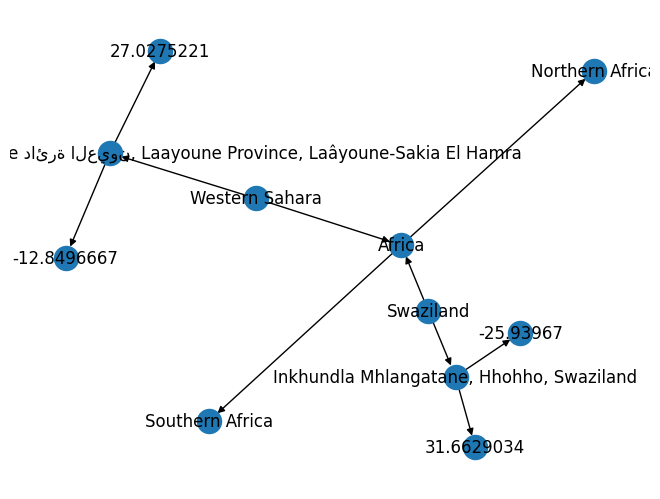

In [187]:
# Testing
G = create_knowledge_graph(train_df[:2])
nx.draw(G, with_labels=True)
plt.show()


In [62]:
import torch
torch_ver = torch.__version__
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -q transformers

  Preparing metadata (setup.py) ... done


## Generate embeddings

### Embedding

In [85]:
from transformers import DistilBertTokenizer, DistilBertModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from threading import Thread
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import networkx as nx
import numpy as np
from tqdm import tqdm



def generate_kge_with_distilbert(graph):
    # Initialize DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

    # Dictionary to store embeddings
    node_embeddings = {}

    # Generate embeddings for each node
    for node in graph.nodes():
        # Convert node to text (assuming the node is already in string format or convertible to string)
        node_text = str(node)

        # Tokenize and generate output
        inputs = tokenizer(node_text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)

        # Extract the hidden state for the [CLS] token (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy()

        # Store the embedding
        node_embeddings[node] = cls_embedding

    return node_embeddings




In [86]:
train_emb = generate_kge_with_distilbert(train_kg)
val_emb = generate_kge_with_distilbert(val_kg)
test_emb = generate_kge_with_distilbert(test_kg)

In [ ]:
val_emb['Ukraine']

In [65]:
val_emb.keys()

dict_keys(['Croatia', 'Klek, Dubrovnik-Neretva, Croatia', 42.9455874, 17.5633131, 'Europe', 'Southern Europe', 'Papua New Guinea', 'Ayate, New Guinea', -4.0539161, 136.3547156, 'Oceania', 'Melanesia', 'Cayman Islands', 'Tulip Close, Grand Cayman, Cayman Islands', 19.3839486, -81.399913, 'Americas', 'Caribbean', 'Mauritius', 'Brown Sequard Street, Plaines Wilhems, Mauritius', -20.3235093, 57.5235259, 'Africa', 'Eastern Africa', 'Saint Martin', 'Impasse des Violenes, Saint Martin', 18.0772043, -63.0695667, 'Ukraine', 'Тунель, Zmiiv Raion, Kharkiv Oblast, Ukraine', 49.5903937, 36.5140179, 'Eastern Europe', 'Azerbaijan', 'Jafar Jabbarly, Sumgayit, Sumqayıt İnzibati Ərazisi, Azerbaijan', 40.5829764, 49.6758711, 'Asia', 'Western Asia', 'Romania', 'Strada Orhideei, Lupeni, Hunedoara, Romania', 45.345921, 23.1898889, 'Palestinian Territory', 'Temraz St, Rafah Governorate, Gaza Strip, Palestinian Territories', 31.2556914, 34.2876053, 'Luxembourg', 'Rue Principale, Wormeldange, Canton Grevenmach

## Extract labels and other data

#### Extract data from Graph

In [104]:
def extract_data_from_graph(graph):
    # Initialize dictionaries
    country_labels = []
    location_longitude = []
    location_latitude = []
    node_types = []
    node_type_to_int = {}
    type_counter = 0
    # Collect unique node types from the graph
    unique_node_types = set(graph.nodes[node].get('type', 'Unknown') for node in graph.nodes)
    node_type_to_int = {node_type: i for i, node_type in enumerate(sorted(unique_node_types))}

    for node, data in graph.nodes(data=True):
        node_type = data.get('type', 'Unknown')
        node_types.append(node_type_to_int.get(node_type, 0))
        # Extract country labels if available
        if data.get('type') == 'Country':
            country_labels.append(node)
        # Extract location coordinates if available
        elif data.get('type') == 'Location_Longitude':
            location_longitude.append(node)
        elif data.get('type') == 'Location_Latitude':
            location_latitude.append(node)




    unique_countries = list(set(country_labels))
    country_to_int = {country: i for i, country in enumerate(unique_countries)}
    country_labels = [country_to_int[name] for name in country_labels]

    return {
            'country_labels':country_labels,
            'location_latitudes':location_latitude,
            'location_longitudes':location_longitude,
            'node_types':node_types,
            'node_type_to_int':node_type_to_int
            }



In [88]:
labels_train = extract_data_from_graph(train_kg)
labels_val = extract_data_from_graph(val_kg)
labels_test = extract_data_from_graph(test_kg)

In [72]:
labels_train['node_type_to_int']

{'Country': 0,
 'Location': 1,
 'Location_Latitude': 2,
 'Location_Longitude': 3,
 'Region': 4,
 'Sub_Region': 5}

## Create PyG dataset

In [134]:
import torch
from torch_geometric.data import Data, Dataset

class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

def create_pyg_dataset(graph, embeddings, labels):
    data_list = []

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors
    y = torch.zeros(num_nodes, 2)  # Assuming 2D coordinates (latitude, longitude)

    for node, idx in node_to_idx.items():
        if labels.get(node):
            y[idx] = torch.tensor(labels[node], dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

    return CustomDataset(data_list)


In [ ]:
def create_pyg_dataset_complexe(graph, embeddings):
    data_list = []

    # Extract data from graph
    extracted_data = extract_data_from_graph(graph)
    location_latitudes = extracted_data['location_latitudes']
    location_longitudes = extracted_data['location_longitudes']

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        print(node)
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors for latitude and longitude
    y_lat = torch.zeros(num_nodes, 1)  # Latitude
    y_lon = torch.zeros(num_nodes, 1)  # Longitude

    for node, idx in node_to_idx.items():
        if node in location_latitudes:
            y_lat[idx] = torch.tensor(float(node), dtype=torch.float)
        if node in location_longitudes:
            y_lon[idx] = torch.tensor(float(node), dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y_lat=y_lat, y_lon=y_lon)
    data_list.append(data)

    return CustomDataset(data_list)

## Build Lat Lon labels

In [135]:
def build_lat_lon_labels(df):
  labels = {}
  for idx, row in df.iterrows():
    location = row['location']
    location_latitude = row['location_latitude']
    location_longitude = row['location_longitude']

    if pd.notna(location) and pd.notna(location_latitude) and pd.notna(location_longitude):
        labels[location] = [location_latitude, location_longitude]
  return labels


In [136]:
labels_train = build_lat_lon_labels(train_df)
labels_val = build_lat_lon_labels(val_df)
labels_test = build_lat_lon_labels(test_df)

In [138]:
train_dataset = create_pyg_dataset(train_kg, train_emb, labels_train)
val_dataset = create_pyg_dataset(val_kg, val_emb, labels_val)
test_dataset = create_pyg_dataset(test_kg, test_emb, labels_test)

## Baseline GCN Model

In [141]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.fc(x)

        return x






## Hyperparameters tuning

In [163]:
# Assume dataset is your PyG dataset and it has been split into train_dataset, val_dataset, and test_dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import optuna

# Objective function to optimize
def objective(trial):
    # Hyperparameters to tune

    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    optimizer = trial.suggest_categorical("optimizer",['adam', 'sgd', 'rmsprop', 'adagrad'])
    scheduler = trial.suggest_categorical("scheduler",['none', 'step', 'cos'])

    # Initialize and train GCN model
    model = GCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(50):  # Fixed number of epochs
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out, batch.y)  # Assuming regression problem
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        for batch in val_loader:
            batch.to(device)
            with torch.no_grad():
                pred = model(batch)
                loss = F.mse_loss(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs
        val_loss /= len(val_loader.dataset)

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



In [174]:
best_trial = study.best_trial
best_lr = best_trial.params['lr']
best_dropout = best_trial.params['dropout']
best_optimizer = best_trial.params['optimizer']
best_scheduler = best_trial.params['scheduler']

## Training

In [175]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader

# Assume study is your Optuna study object
best_trial = study.best_trial

best_lr = best_trial.params['lr']
best_dropout = best_trial.params['dropout']
best_optimizer = best_trial.params['optimizer']
best_scheduler = best_trial.params['scheduler']

# Initialize model, optimizer, and data loader
num_features = train_dataset.num_features
num_classes = 2  # For latitude and longitude
model = GCN(num_features, num_classes).to(device)

'step'

Training: 100%|██████████| 300/300 [00:02<00:00, 117.02epoch/s]


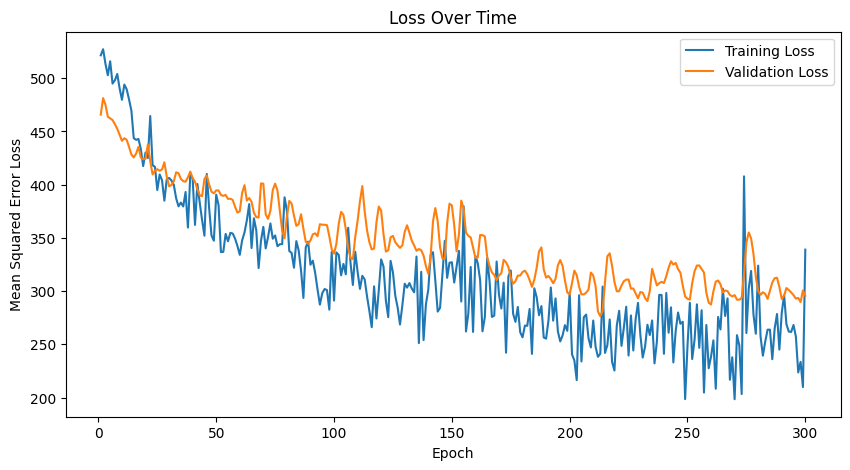

Test Loss: 295.67999267578125


In [177]:
num_features = train_dataset.num_features  # Replace with the number of features in your node feature matrix
num_classes = 2  # For latitude and longitude
model = GCN(num_features, num_classes).to(device)

if best_optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
elif best_optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
elif best_optimizer == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr)
elif best_optimizer == 'adagrad':
    optimizer = torch.optim.Adagrad(model.parameters(), lr=best_lr)


if best_scheduler == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
elif best_scheduler == 'cos':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=30, gamma=0.1)
elif best_scheduler == 'none':
    scheduler = None



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epoch = 300
train_loss_values = []
val_loss_values = []

# Training loop
num_epochs = 300
for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    train_epoch_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item() * batch.num_graphs

    train_epoch_loss /= len(train_loader.dataset)
    train_loss_values.append(train_epoch_loss)

    # Validation loop
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            val_epoch_loss += loss.item() * batch.num_graphs

    val_epoch_loss /= len(val_loader.dataset)
    val_loss_values.append(val_epoch_loss)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        test_loss += loss.item() * batch.num_graphs

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


In [178]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model.eval()
with torch.no_grad():
    predictions = model(test_dataset.get(0)).cpu().numpy()
    labels = test_dataset.get(0).y.cpu().numpy()

# Calculate MAE, MSE, RMSE, and R-Squared
mae = mean_absolute_error(labels, predictions)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels, predictions)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R-Squared: {r2}")

MAE: 7.608048439025879, MSE: 295.6799621582031, RMSE: 17.19534683227539, R-Squared: 0.40984501754489533


##  Descriptive Statistics Of the model with haversine_distances

In [180]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(coord1, coord2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Calculate Haversine distances for all nodes
haversine_distances = np.array([haversine_distance(true_coord, pred_coord) for true_coord, pred_coord in zip(labels, predictions)])

print(f"Mean Haversine Distance: {np.mean(haversine_distances)} km")


Mean Haversine Distance: 1295.4565860081477 km


In [181]:
import numpy as np
from scipy import stats


mean_distance = np.mean(haversine_distances)
median_distance = np.median(haversine_distances)
std_dev = np.std(haversine_distances)
min_distance = np.min(haversine_distances)
max_distance = np.max(haversine_distances)
quartiles = np.percentile(haversine_distances, [25, 50, 75])
skewness = stats.skew(haversine_distances)
kurtosis = stats.kurtosis(haversine_distances)

print(f"Mean: {mean_distance}, Median: {median_distance}, Std Dev: {std_dev}")
print(f"Min: {min_distance}, Max: {max_distance}")
print(f"Quartiles: {quartiles}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

Mean: 1295.4565860081477, Median: 152.8296362883828, Std Dev: 2249.932249819579
Min: 84.42509527691934, Max: 14593.908733143238
Quartiles: [ 102.12263315  152.82963629 1558.18618865]
Skewness: 3.4099996669781723, Kurtosis: 15.085643994989187


# Robust Models

## Generate the Knowledge Graph

## Generate Embeddings


##Extract labels and other data

## Create PyG dataset

## Build Lat Lon Labels

## Robuste Models

### GCN

### GRaphSage

### GAT Model

# Multi Tasks Models